# Overview #

The objective of this task is to build a model that predicts the quality of red wine given certain features. Wine quality ranges from 0 (poor) to 10 (excellent).

# Import libraries & define some variables #

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

TRAIN_DATASET = os.path.join('dataset', 'winequality_white.csv')

# Data Inspection and Preprocessing #

In [2]:
data = pd.read_csv(TRAIN_DATASET)
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Luckily, this dataset does not have any `NaN` values and all inputs are numeric.

# Exploratory Data Analysis #

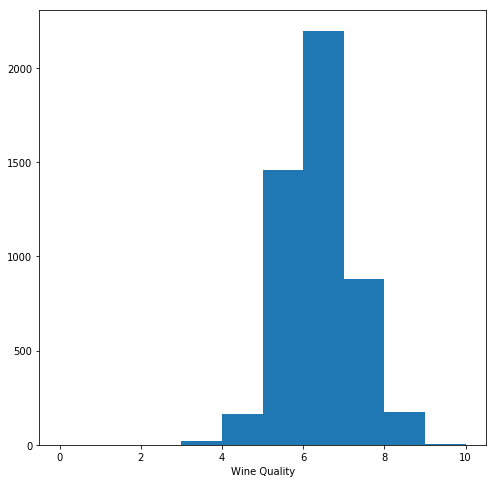

In [4]:
plt.figure(figsize=(8, 8))
plt.hist(df['quality'], range=(0, 10))
plt.xlabel('Wine Quality')
plt.show()

Most of the red wine samples provided fall between 5 and 7; meaning that they are mostly good wine (not excellent). This could affect the strength of prediction of the model since it will learn more of what makes red wine good.

Studying the correlation between the features will give an idea of what features really affect wine quality positively or negatively.

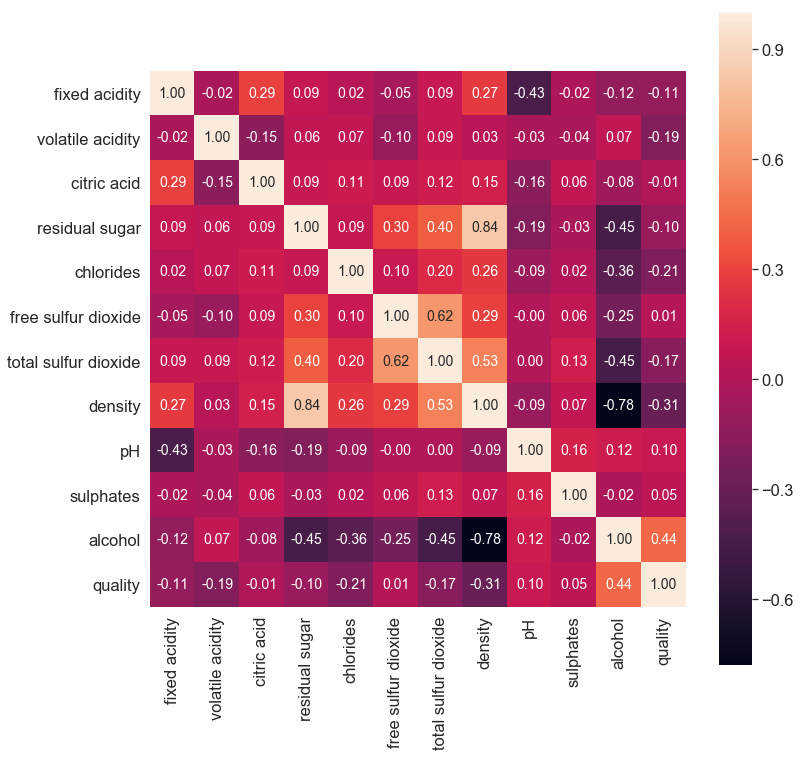

In [5]:
def heatmap(df):
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.5)
    sns.heatmap(df.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=df.columns, 
                xticklabels=df.columns)
    plt.show()
    
heatmap(df)

We will exam features with strong correlation (>=0.43) between them.

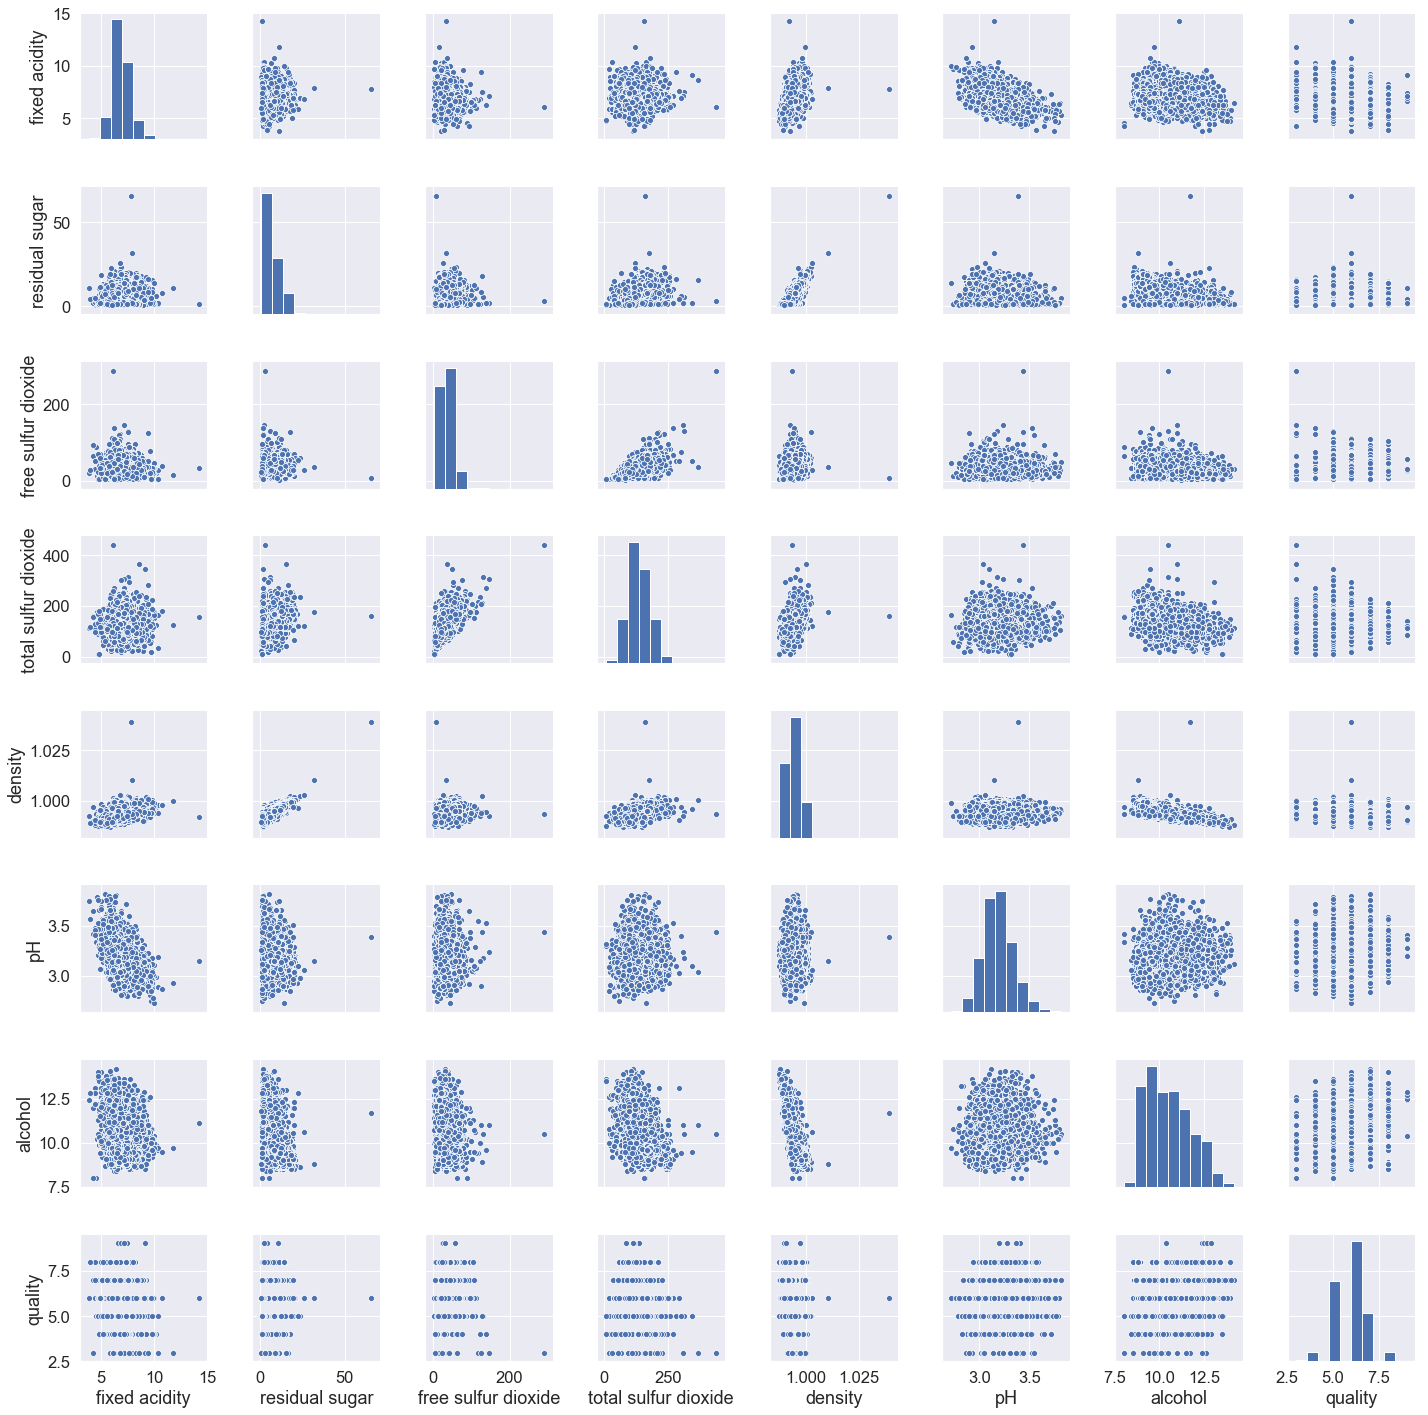

In [6]:
corr_cols = ['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 
             'alcohol', 'quality']

def pairplot(cols):
    sns.pairplot(df[cols])
    plt.show()
    
pairplot(corr_cols)

# Looking out for outliers #

The approach to be applied to looking for outliers will be to compare correlations between features and view the plot of points between these correlations. Correlation values greater than 0.5 and have "eye-balled" outliers from the pairplot will be analyzed.

In [7]:
from scipy import stats
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import polyfit
import random

def plot_relationship_best_fit(x_axis, x_label, y_axis, y_label, best_fit='linear'):
    fit = None
    
    if best_fit == 'linear':
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
        fit = slope * x_axis + intercept
#         c = polyfit(x_axis, y_axis, 1)
#         fit = c[0] + c[1]*x_axis
    
    if best_fit == 'quadratic':
        popt, pcov = curve_fit(func, x_axis, y_axis)
        fit = func(x_axis, *popt)
        
#         coef = polyfit(x_axis, y_axis, 2)
#         fit = coef[0] + coef[1]*x_axis + coef[2]*(x_axis**2)
        
    np.random.seed(42)
    r = random.randint(0, len(x_axis)-1)
    
    plt.figure(figsize=(8,8))    
    plt.scatter(x_axis, y_axis)
    plt.plot(x_axis, fit, color='r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def func(x, a, b, c):
    return a*(x**2) + b*x + c

In [8]:
def corr_plot(x_axis, x_label, y_axis, y_label, title=None, legend=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_axis, y_axis)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

#### Residual Sugar & Density ####

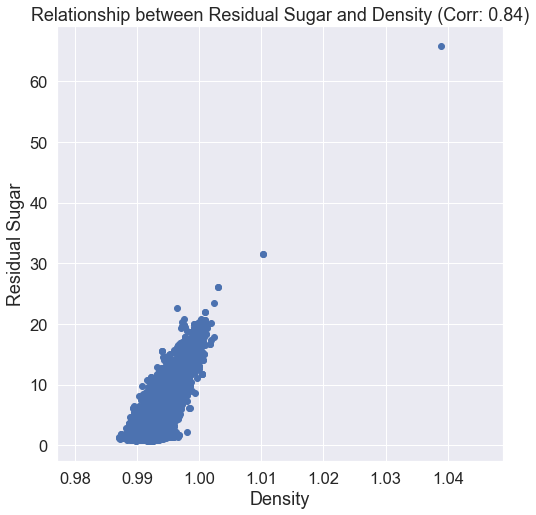

In [9]:
corr = 'Corr: %.2f' % df['residual sugar'].corr(df['density'])
corr_plot(df['density'], 'Density', df['residual sugar'], 'Residual Sugar', 
          'Relationship between Residual Sugar and Density ({})'.format(corr))

Residual sugar and density are highly positively correlated, therefore, there is no need to remove outliers.

#### Total Sulfur Dioxide & Density ####

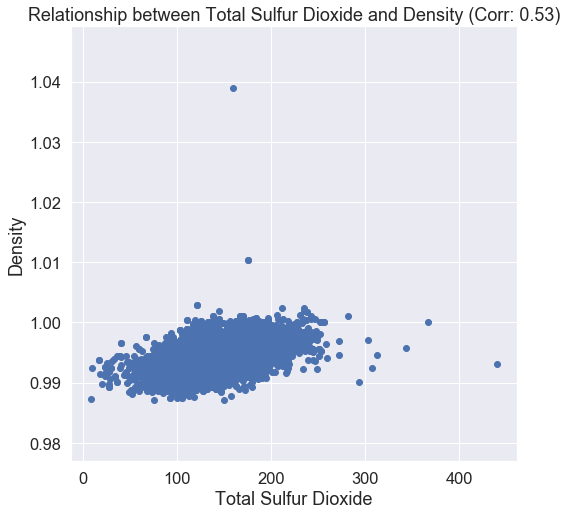

In [10]:
corr = 'Corr: %.2f' % df['total sulfur dioxide'].corr(df['density'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['density'], 'Density', 
          'Relationship between Total Sulfur Dioxide and Density ({})'.format(corr))

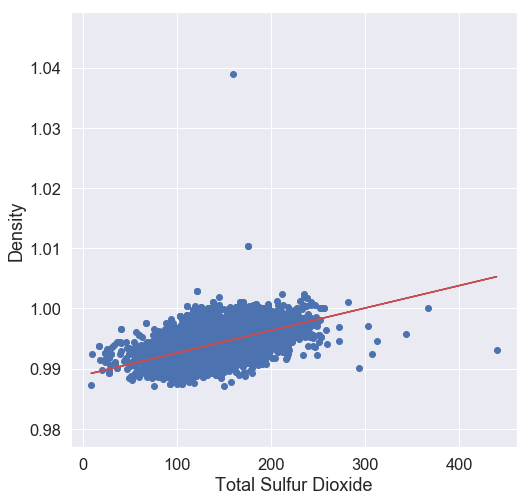

In [11]:
plot_relationship_best_fit(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['density'], 'Density')

Total sulfur dioxide and density are positively correlated. Outliers can easily be "eyeballed". Density above 1.01 are too extreme cases that need to be removed. Total sulfur dioxide cases more than 300 will also be removed.

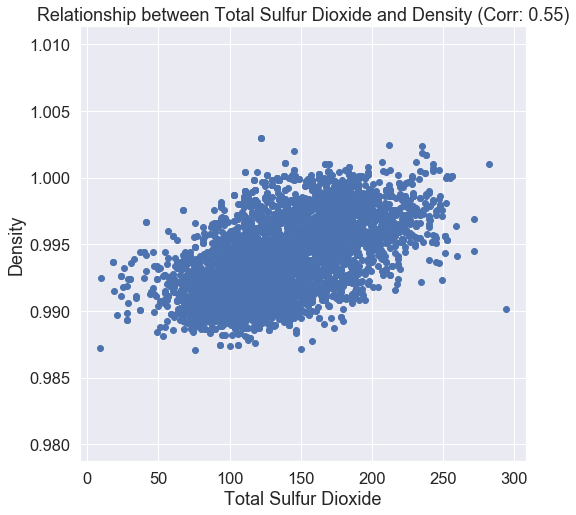

In [12]:
df = df[df['density'] < 1.01]
df = df[df['total sulfur dioxide'] < 300]

corr = 'Corr: %.2f' % df['total sulfur dioxide'].corr(df['density'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['density'], 'Density', 
          'Relationship between Total Sulfur Dioxide and Density ({})'.format(corr))

#### Density & Alcohol ####

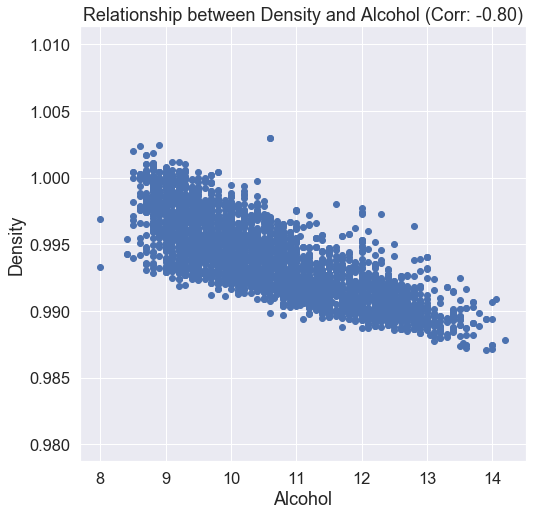

In [13]:
corr = 'Corr: %.2f' % df['density'].corr(df['alcohol'])
corr_plot(df['alcohol'], 'Alcohol', df['density'], 'Density', 
          'Relationship between Density and Alcohol ({})'.format(corr))

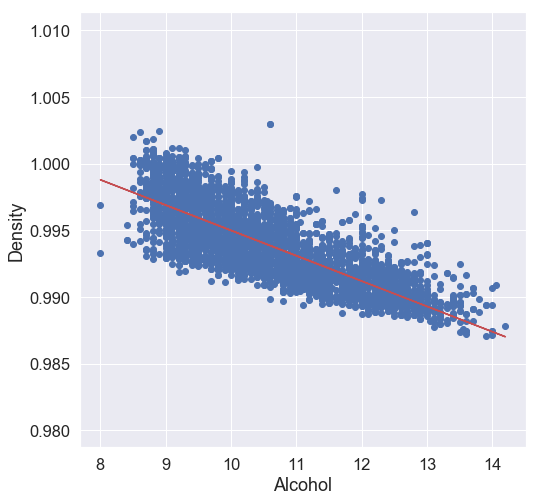

In [14]:
plot_relationship_best_fit(df['alcohol'], 'Alcohol', df['density'], 'Density')

#### Free Sulfur Dioxide & Total Sulfur Dioxide ####

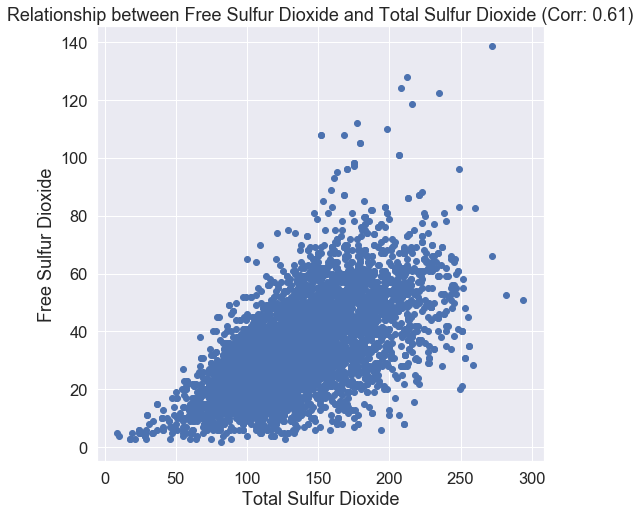

In [15]:
corr = 'Corr: %.2f' % df['free sulfur dioxide'].corr(df['total sulfur dioxide'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['free sulfur dioxide'], 'Free Sulfur Dioxide', 
          'Relationship between Free Sulfur Dioxide and Total Sulfur Dioxide ({})'.format(corr))

Free sulfur dioxide and total sulfur dioxide are positively correlated and the plot can be used as is without removing outliers.

In [16]:
df.shape

(4889, 12)

# Feature Engineering #

Features will be engineered to create new features based on the relationship between the features and their correlation. From research, total acidity is made up of fixed acidity and volatile acidity. These features will be combined to one feature. Features that have a correlation greater than 0.4 will be combined to form new features.

In [17]:
df['total acidity'] = df['fixed acidity'] + df['volatile acidity']
df['alcohol density'] = df['alcohol'] * df['density']
df['residual sugar density'] = df['residual sugar'] * df['density']
df['total sulfur dioxide density'] = df['total sulfur dioxide'] * df['density']
df['sulfur dioxide content'] = df['total sulfur dioxide'] * df['free sulfur dioxide']
df['alcohol quality'] = df['alcohol'] * df['quality']

df.drop(['alcohol', 'density', 'fixed acidity', 'volatile acidity', 'total sulfur dioxide', 
         'free sulfur dioxide'], axis=1, inplace=True)

df = df.reset_index(drop=True)

In [18]:
from sklearn.preprocessing import PolynomialFeatures

random_state = 42
target = df['quality']
features = df.drop('quality', axis=1)

# poly = PolynomialFeatures(2)
# features = poly.fit_transform(features)
features.shape

(4889, 11)

In [19]:
df.shape

(4889, 12)

# Feature Scaling #

With outliers removed, the dataset will be scaled using the `StandardScaler` class. But first the data will be split into training and testing sets with a ration of 70% to 30%.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=random_state)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3422, 11)
(1467, 11)
(3422,)
(1467,)


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model #

The model will be trained on the default hyperparameters of `Linear Regressor`, `Ridge`, `Lasso`, `ElasticNet`, `Random Forest Regressor`, `Gradient Boosting Regressor`, `Ada Boost Regressor`, `Decision Tree Regressor` and `Support Vector Regressor`.

The performance of the model will be evaluated using its `r2 score`.

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

def experimentation_scores(scores):
    return scores.mean()

### Decision Tree Regressor ###

In [23]:
model = DecisionTreeRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dtr_score = experimentation_scores(scores)

### Linear Regressor ###

In [24]:
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
lr_score = experimentation_scores(scores)

### Ridge ###

In [25]:
model = Ridge(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
ri_score = experimentation_scores(scores)

### Lasso ###

In [26]:
model = Lasso(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
la_score = experimentation_scores(scores)

### ElasticNet ###

In [27]:
model = ElasticNet(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
el_score = experimentation_scores(scores)

### Gradient Boosting Regressor ###

In [28]:
model = GradientBoostingRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
gbr_score = experimentation_scores(scores)

### Random Forest Regressor ###

In [29]:
model = RandomForestRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
rfr_score = experimentation_scores(scores)

C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

### Ada Boost Regressor ###

In [30]:
model = AdaBoostRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
abr_score = experimentation_scores(scores)

### SVR ###

In [31]:
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
svr_score = experimentation_scores(scores)

C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Plot default performance.

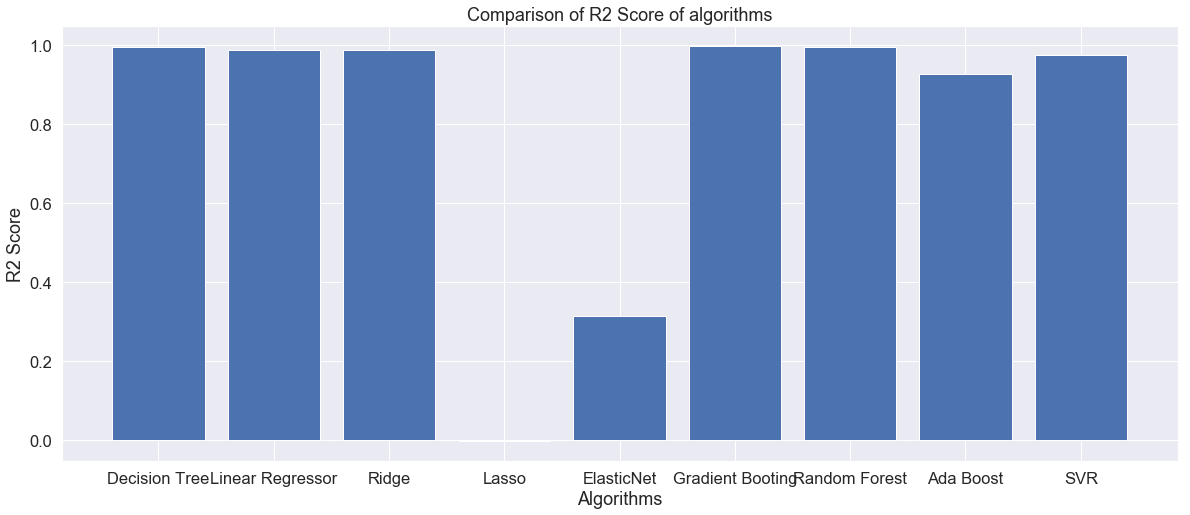

In [32]:
x = np.arange(9)
plt.figure(figsize=(20, 8))
plt.bar(x, [dtr_score, lr_score, ri_score, la_score, el_score, gbr_score, rfr_score, abr_score, svr_score])
plt.xticks(x, ('Decision Tree', 'Linear Regressor', 'Ridge', 'Lasso', 'ElasticNet', 'Gradient Booting', 'Random Forest', 
               'Ada Boost', 'SVR'))
plt.title('Comparison of R2 Score of algorithms')
plt.xlabel('Algorithms')
plt.ylabel('R2 Score')
plt.show()

Using default values, `DecisionTreeRegressor`, `GradientBoostingRegressor` and `RandomForestRegressor` narrowly edge out the other algorithms. Since there are three options to choose from, `RandomForestRegressor` will be used to train the model.

# Fine-tune model #

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

RandomizedSearchCV is a class provided by scikit-learn that will experiment with hyperparameters, tuning the model to determine which combination of hyperparameters gives the best outcome. RandomizedSearchCV randomly combines hyperparameters in each iteration.

It is important to note that RandomizedSearchCV can give different hyperparameter combination when run multiple time.

In [34]:
scoring = 'r2'
n_jobs = -1
n_iter = 100

param_distributions = {
    'max_depth': [2, 3, 4, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

model = RandomForestRegressor(random_state=random_state)
random_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=n_iter, scoring=scoring, 
                                   n_jobs=n_jobs, cv=cv, verbose=1, return_train_score=True)
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 759 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   20.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.1s finished
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [2, 3, 4, 6, 8, 10], 'min_samples_split': [2, 3, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=1)

In [35]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [36]:
param_grid = [{
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1150, 1500, 2000]
}]

grid_search = GridSearchCV(random_search.best_estimator_, param_grid, cv=cv, scoring=scoring, 
                           n_jobs=n_jobs, verbose=1, return_train_score=True)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  4.8min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1150, 1500, 2000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=cv, 
                                                         scoring=scoring, n_jobs=n_jobs, verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

[learning_curve] Training set sizes: [ 307 1000 1693 2386 3079]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(train_sizes, train_scores_mean, label='Training scores')
plt.plot(train_sizes, val_scores_mean, label='Cross validation scores')
plt.xlabel('Train size')
plt.ylabel('Score')
plt.legend()
plt.show()

The wide margin between the training and validation scores indicate that the model overfits. Provide more data will help in reducing overfitting.

## Train the best estimator ##

In [40]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model #

In [41]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, np.round(predictions))
print('R2 Score: %.3f' % r2)

R2 Score: 0.999


The plot below compares the predictions of the model with the corresponding ground-truth values.

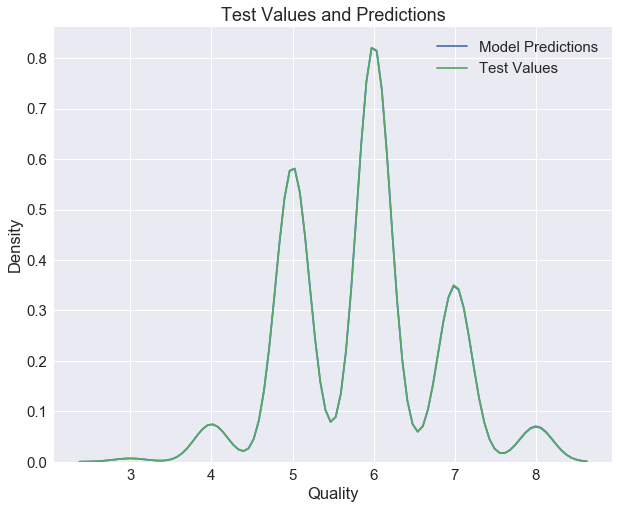

In [42]:
def evaluation_plot(y_test, predictions):
    plt.figure(figsize=(10, 8))

    # Density plot of the final predictions and the test values
    sns.kdeplot(predictions, label='Model Predictions')
    sns.kdeplot(y_test, label='Test Values')

    # Label the plot
    plt.xlabel('Quality')
    plt.ylabel('Density')
    plt.title('Test Values and Predictions')
    plt.show()

evaluation_plot(y_test, np.round(predictions))